# Coronavirus Global Cases Predictions with RandomForest Regression 

In [1]:
### import libraries
import pandas as pd #Dataframe manipulation library
import numpy as np #Library to handle data in a vectorized manner
import matplotlib.pyplot as plt #Matplotlib and associated plotting modules
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib import style
import math #Math functions
import requests #library to handle requests
import os
import random
import time
import datetime
import warnings

# Dataset

This data is collected from repository for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE).https://github.com/CSSEGISandData/COVID-19

In [2]:
warnings.filterwarnings("ignore")

In [3]:
###Import the data from CSSE at Johns Hopkins University (https://systems.jhu.edu/)
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [4]:
###Index columns as DataFrame series
cols = confirmed_df.keys()

In [5]:
###Get all the dates for the outbreak
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [6]:
### Replace NaN values by 0
confirmed_df.fillna(0, inplace=True)
deaths_df.fillna(0, inplace=True)
recoveries_df.fillna(0, inplace=True)

In [7]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
active_cases = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)
    total_recovered.append(recovered_sum)
    active_cases.append(confirmed_sum-(recovered_sum+death_sum))
    active_cases_sum=(confirmed_sum-(recovered_sum+death_sum)).sum()

In [8]:
###Convert integer into datetime for better visualization
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')

In [9]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)
active_cases = np.array(active_cases).reshape(-1, 1)

In [10]:
###Future forecast
days_in_future = 3
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
adjusted_dates = future_forcast_dates[:-3]

### Coronavirus Predictions using Support-Vector Machine with Polynomial and Radial Basis Function kernels

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [12]:
warnings.filterwarnings("ignore")

In [13]:
# Train parameters to predict labels, use 20% for Test set
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.2, shuffle=False) 
X_train_recovered, X_test_recovered, y_train_recovered, y_test_recovered = train_test_split(days_since_1_22, total_recovered, test_size=0.2, shuffle=False)
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(days_since_1_22, total_deaths, test_size=0.2, shuffle=False)
X_train_active, X_test_active, y_train_active, y_test_active = train_test_split(days_since_1_22, active_cases, test_size=0.2, shuffle=False) 
X_train_mortality, X_test_mortality, y_train_mortality, y_test_mortality = train_test_split(days_since_1_22, mortality_rate , test_size=0.2, shuffle=False) 
X_train_recovery, X_test_recovery, y_train_recovery, y_test_recovery = train_test_split(days_since_1_22, recovery_rate, test_size=0.2, shuffle=False) 

In [14]:
# Establish model
model= RandomForestRegressor()

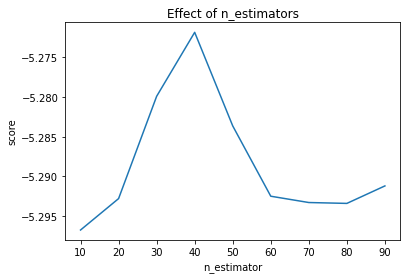

In [15]:
# Try different numbers of n_estimators
estimators = np.arange(10, 100, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train_recovered, y_train_recovered)
    scores.append(model.score(X_test_confirmed, y_test_confirmed))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [16]:
ensemble_grid =  {'n_estimators': [100],
                 'criterion': ['mse', 'mae'],
                 'bootstrap': [True, False],
                 'max_depth': [7],}
ensemble = RandomForestRegressor()

In [17]:
ensemble_search_confirmed = RandomizedSearchCV(ensemble, ensemble_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
ensemble_search_confirmed.fit(X_train_confirmed, y_train_confirmed.ravel())
ensemble_confirmed = ensemble_search_confirmed.best_estimator_
ensemble_pred_confirmed = ensemble_confirmed.predict(future_forcast)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.6s finished


In [18]:
ensemble_search_recovered = RandomizedSearchCV(ensemble, ensemble_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
ensemble_search_recovered.fit(X_train_recovered, y_train_recovered.ravel())
ensemble_recovered = ensemble_search_recovered.best_estimator_
ensemble_pred_recovered = ensemble_recovered.predict(future_forcast)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished


In [19]:
ensemble_search_deaths = RandomizedSearchCV(ensemble, ensemble_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
ensemble_search_deaths.fit(X_train_deaths, y_train_deaths.ravel())
ensemble_deaths = ensemble_search_deaths.best_estimator_
ensemble_pred_deaths = ensemble_deaths.predict(future_forcast)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished


In [20]:
ensemble_search_active = RandomizedSearchCV(ensemble, ensemble_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
ensemble_search_active.fit(X_train_active, y_train_active.ravel())
ensemble_active = ensemble_search_active.best_estimator_
ensemble_pred_active = ensemble_active.predict(future_forcast)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


In [21]:
ensemble_search_mortality = RandomizedSearchCV(ensemble, ensemble_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
ensemble_search_mortality.fit(X_train_mortality, y_train_mortality)
ensemble_mortality = ensemble_search_mortality.best_estimator_
ensemble_pred_mortality = ensemble_mortality.predict(future_forcast)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


In [22]:
ensemble_search_recovery = RandomizedSearchCV(ensemble, ensemble_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
ensemble_search_recovery.fit(X_train_recovery, y_train_recovery)
ensemble_recovery = ensemble_search_recovery.best_estimator_
ensemble_pred_recovery = ensemble_recovery.predict(future_forcast)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


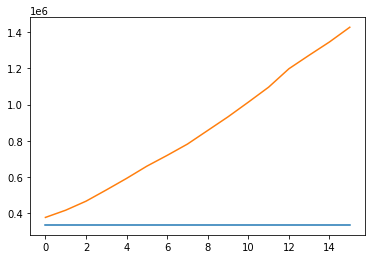

In [23]:
# check against testing data
ensemble_test_pred = ensemble_confirmed.predict(X_test_confirmed)
plt.ylim()
plt.plot(ensemble_test_pred)
plt.plot(y_test_confirmed)

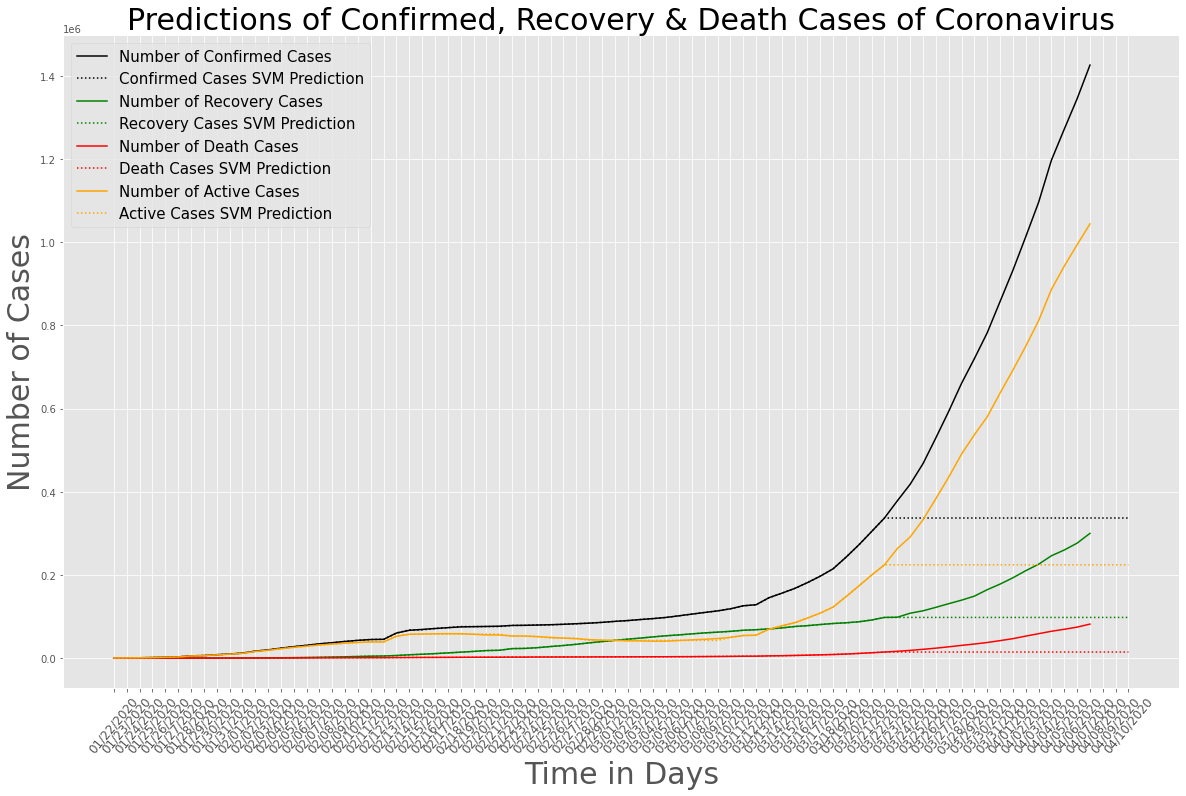

In [24]:
plt.figure(figsize=(20, 12))
plt.style.use('ggplot')
plt.plot(adjusted_dates, world_cases, color='black')
plt.plot(future_forcast_dates, ensemble_pred_confirmed, linestyle='dotted', color='black')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.plot(future_forcast_dates, ensemble_pred_recovered, linestyle='dotted', color='green')
plt.plot(adjusted_dates, total_deaths, color='red')
plt.plot(future_forcast_dates, ensemble_pred_deaths, linestyle='dotted', color='red')
plt.plot(adjusted_dates, active_cases, color='orange')
plt.plot(future_forcast_dates, ensemble_pred_active, linestyle='dotted', color='orange')
plt.title('Predictions of Confirmed, Recovery & Death Cases of Coronavirus', size=30)
plt.legend(['Number of Confirmed Cases', 'Confirmed Cases SVM Prediction', 'Number of Recovery Cases', 'Recovery Cases SVM Prediction', 'Number of Death Cases', 'Death Cases SVM Prediction', 'Number of Active Cases', 'Active Cases SVM Prediction','Number of Confirmed Cases',  'Confirmed Cases SVM Prediction', 'Number of Active Cases', 'Active Cases SVM Prediction'], loc='upper left', fontsize=15)
plt.xlabel('Time in Days', size=30)
plt.ylabel('Number of Cases', size=30)
plt.xticks(rotation=50, size=12)
plt.show()

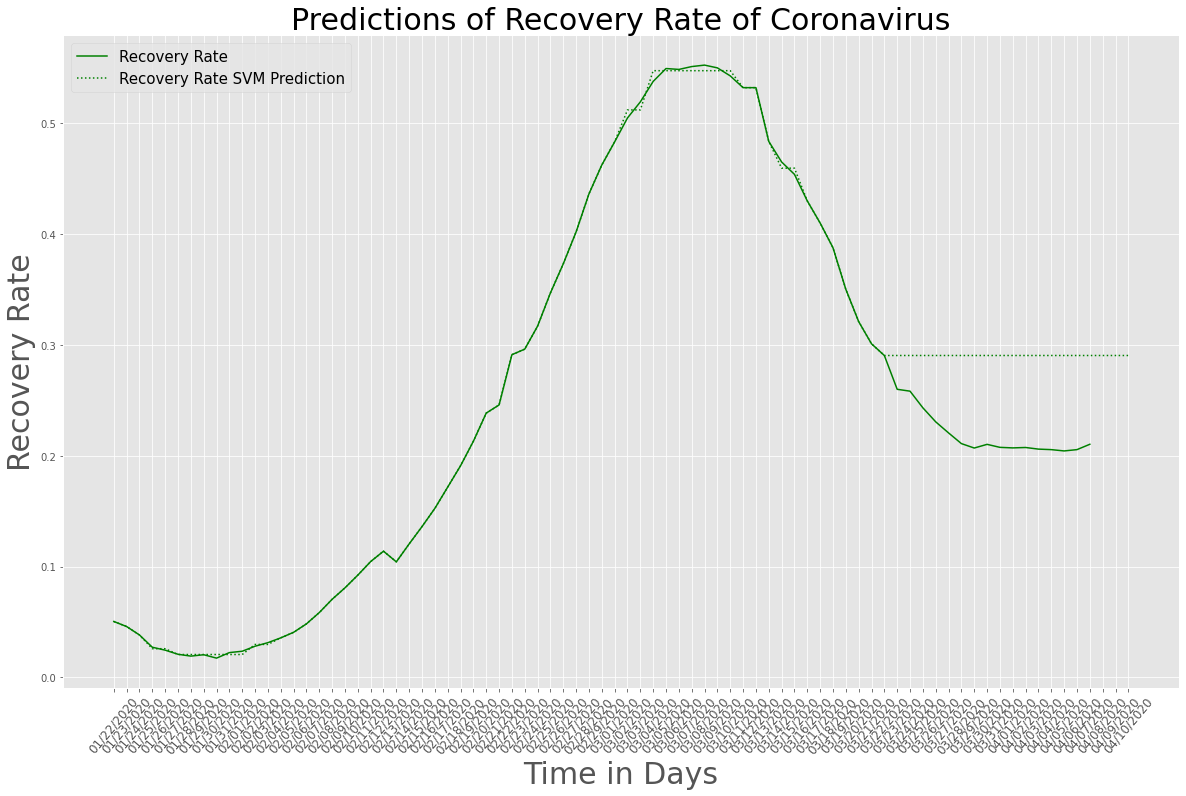

In [25]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, recovery_rate, color='green')
plt.plot(future_forcast_dates,ensemble_pred_recovery , linestyle='dotted', color='green')
plt.title('Predictions of Recovery Rate of Coronavirus', size=30)
plt.legend(['Recovery Rate',  'Recovery Rate SVM Prediction'], loc='upper left', fontsize=15)
plt.xlabel('Time in Days', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(rotation=50, size=12)
plt.show()

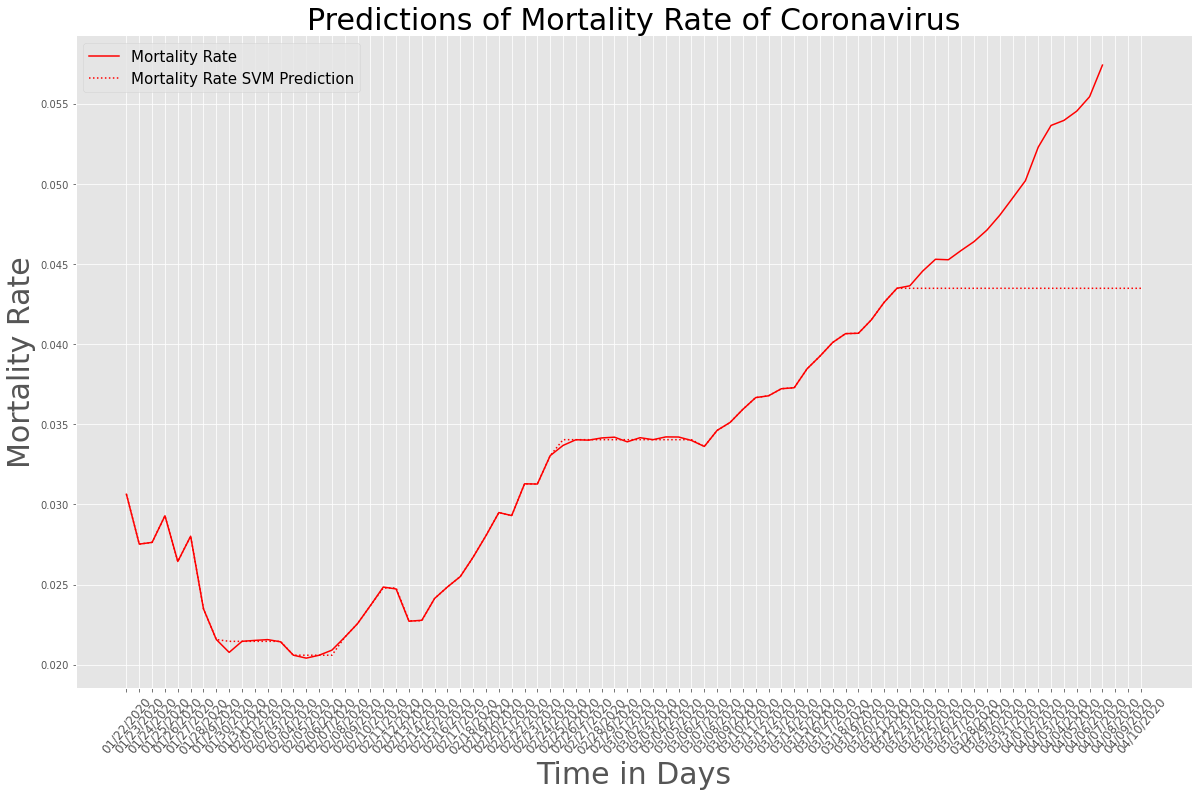

In [26]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, mortality_rate, color='red')
plt.plot(future_forcast_dates, ensemble_pred_mortality, linestyle='dotted', color='red')
plt.title('Predictions of Mortality Rate of Coronavirus', size=30)
plt.legend(['Mortality Rate', 'Mortality Rate SVM Prediction'], loc='upper left', fontsize=15)
plt.xlabel('Time in Days', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(rotation=50, size=12)
plt.show()